In [1]:
import fnmatch
import os
import re
import numpy as np
import pandas as pd
from matplotlib import cm
import seaborn as sns

In [2]:
def get_val_losses(file_list, col_ref='val_ou', avg_over=50, epochs=None):
    '''
    Returns a concatenated array with arrays in the list. \n
    Concatenation will be performed along axis=1
    Populates missing entries with nans.'''
            
    best_loss_list=[]
    all_loss_list=[]
    
    for file in file_list:
        df = pd.read_csv(file,index_col=False)
        
        col_list = [loss for loss in df.columns.tolist() if col_ref in loss]
        val_losses = df[col_list].values
        
        if epochs is None:
            epochs=val_losses.shape[0]
        best_ind = np.argmax(np.mean(val_losses[epochs-avg_over:epochs,:],axis=0))
        
        best_loss_list.append(val_losses[:,best_ind])
        all_loss_list.append(val_losses)
    
    return best_loss_list, all_loss_list

def arraylist_to_array(arr_list):
    '''
    Returns a concatenated array with arrays in the list. \n
    Assumes each list element is non empty
    Concatenation will be performed along axis=1
    Populates missing entries with nans.'''
    
    row_list = [arr.shape[0] for arr in arr_list]
    col_list = [arr.shape[1] if arr.ndim>1 else 1 for arr in arr_list]
    n_rows = np.max(np.array(row_list))
    n_cols = np.sum(np.array(col_list))
      
    A = np.empty([n_rows,n_cols])
    A.fill(np.nan)
    
    startval=0
    for i,arr in enumerate(arr_list):        
        A[:row_list[i],startval:(startval+col_list[i])]=arr.reshape(row_list[i],col_list[i])
        startval=startval+col_list[i]
    
    return A    

**Compare $C_{MSV}$ and $C_{MSV}$ over different latent space dimensionality**

In [3]:
#Data folder with 
data_dir = './data/results/cost_fcn/logs/'
file_list = [file for file in os.listdir(data_dir) if fnmatch.fnmatch(file, '*.csv')]

file_list_dict = {}
recon_loss={}
cpl_loss={}

for ndims in ['2','10','50']:
    file_list_dict[ndims+'_mineig'] = [data_dir+file for file in file_list if 'ld_'+ndims+'_cs_1-0_cf_mineig_bs_400' in file]
    file_list_dict[ndims+'_mineig'].sort()
    
    file_list_dict[ndims+'_fullcov'] = [data_dir+file for file in file_list if 'ld_'+ndims+'_cs_1-0_cf_fullcov_bs_400' in file]
    file_list_dict[ndims+'_fullcov'].sort()

for key in file_list_dict:
    recon_loss[key] = get_val_losses(file_list_dict[key], col_ref='val_ou_ae', avg_over=50, epochs=None)[1]
    cpl_loss[key]   = get_val_losses(file_list_dict[key], col_ref='val_ld_ae', avg_over=50, epochs=None)[1]
    
for key in file_list_dict:
    recon_loss[key] = arraylist_to_array(recon_loss[key])
    cpl_loss[key]   = arraylist_to_array(cpl_loss[key])

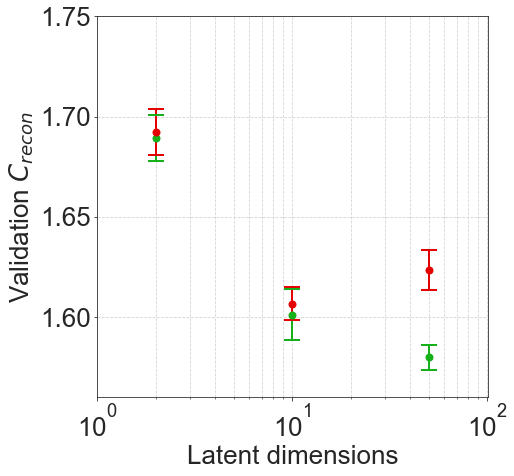

In [4]:
legend_txt_size = 16
ax_txt_size = 26
cc=['#15b01a','#e50000']

sns.set_style('ticks')
fig_2C = plt.figure(figsize=(7, 7))
fc_arr = np.empty((0,3))
me_arr = np.empty((0,3))   

#jobs killed before completion have nans
for i,key in enumerate(['2','10','50']):
    X = np.mean(recon_loss[key+'_fullcov'][-50:,:],axis=0)
    fc_arr = np.append(fc_arr,np.array([[np.float(key),np.nanmean(X),np.nanstd(X)]]),axis=0)
    
    X = np.mean(recon_loss[key+'_mineig'][-50:,:],axis=0)
    me_arr = np.append(me_arr,np.array([[np.float(key),np.nanmean(X),np.nanstd(X)]]),axis=0)
    
plt.errorbar(me_arr[:,0],me_arr[:,1],me_arr[:,2],
             fmt='.', mfc=cc[0], mec='None', ms=16, mew=2,
             ecolor=cc[0], elinewidth=2, capsize=8, 
             label=r'$C_{\rm{MSV}}$')

plt.errorbar(fc_arr[:,0],fc_arr[:,1],fc_arr[:,2],
             fmt='.', mfc=cc[1], mec='None', ms=16, mew=2,
             ecolor=cc[1], elinewidth=2, capsize=8, 
             label=r'$C_{\rm{FC}}$')

ax=plt.gca()
ax.set_xscale('log')
plt.grid(True,which="both",ls="--",c='lightgray')  
ax.set_xlim(1,101)
ax.set_ylim(1.56,1.75)
ax.set_yticks(np.arange(1.6,1.76,0.05))
ax.set_xlabel('Latent dimensions')
ax.set_ylabel('Validation $C_{recon}$')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(ax_txt_size)
    
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(ax_txt_size)

fig_2C.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig1C.pdf',
               dpi=300, format='pdf', bbox_inches='tight')

**Compare $C_{MSV}$ and $C_{MSV}$ over different batch sizes**
 - Latent dimensionality is fixed `d=10`
 - Similar trend with `d=20`

In [5]:
data_dir = './data/results/batch_size/logs/'
file_list = [file for file in os.listdir(data_dir) if fnmatch.fnmatch(file, '*.csv')]

file_list_dict = {}
recon_loss={}
cpl_loss={}

for bs in ['25','50','100','200','800']:
    file_list_dict['mineig_ld10_bs'+bs] = [data_dir+file for file in file_list if 'ld_10_cs_1-0_cf_mineig_bs_'+bs in file]
    file_list_dict['mineig_ld10_bs'+bs].sort()

    file_list_dict['fullcov_ld10_bs'+bs] = [data_dir+file for file in file_list if 'ld_10_cs_1-0_cf_fullcov_bs_'+bs in file]
    file_list_dict['fullcov_ld10_bs'+bs].sort()
    
for key in file_list_dict:
    recon_loss[key] = get_val_losses(file_list_dict[key], col_ref='val_ou_ae', avg_over=50, epochs=None)[1]
    cpl_loss[key]   = get_val_losses(file_list_dict[key], col_ref='val_ld_ae', avg_over=50, epochs=None)[1]

for key in file_list_dict:
    recon_loss[key] = arraylist_to_array(recon_loss[key])
    cpl_loss[key]   = arraylist_to_array(cpl_loss[key])

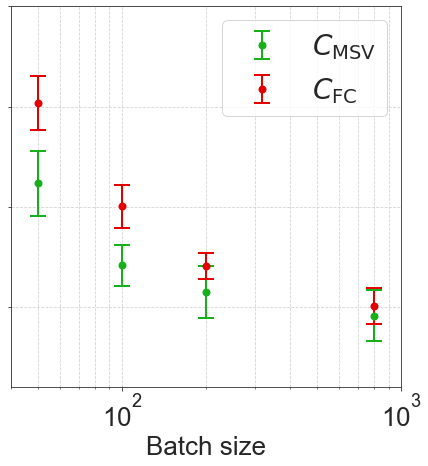

In [6]:
legend_txt_size = 28
ax_txt_size = 26
cc=['#15b01a','#e50000']

sns.set_style('ticks')
fig_2D = plt.figure(figsize=(7, 7))
fc_arr = np.empty((0,3))
me_arr = np.empty((0,3))   

for i,key in enumerate(['25','50','100','200','800']):
    X = np.mean(recon_loss['fullcov_ld10_bs'+key][-50:,4:],axis=0)
    fc_arr = np.append(fc_arr,np.array([[np.float(key),np.nanmean(X),np.nanstd(X)]]),axis=0)
    
    X = np.mean(recon_loss['mineig_ld10_bs'+key][-50:,4:],axis=0)
    me_arr = np.append(me_arr,np.array([[np.float(key),np.nanmean(X),np.nanstd(X)]]),axis=0)
    
plt.errorbar(me_arr[:,0],me_arr[:,1],me_arr[:,2],
             fmt='.', mfc=cc[0], mec='None', ms=16, mew=2,
             ecolor=cc[0], elinewidth=2, capsize=8, 
             label=r'$C_{\rm{MSV}}$')
plt.errorbar(fc_arr[:,0],fc_arr[:,1],fc_arr[:,2],
             fmt='.', mfc=cc[1], mec='None', ms=16, mew=2,
             ecolor=cc[1], elinewidth=2, capsize=8, 
             label=r'$C_{\rm{FC}}$')

ax = plt.gca()
ax.set_xscale('log')
plt.grid(True,which="both",ls="--",c='lightgray')  
ax.set_xlim(40,1000)
ax.set_ylim(1.56,1.75)
ax.set_yticks(np.arange(1.6,1.76,0.05))
ax.set_yticklabels('')
ax.set_xlabel('Batch size')
ax.legend(prop={'size': legend_txt_size})

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(ax_txt_size)
    
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(ax_txt_size)

fig_2D.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig1D.pdf',
               dpi=300, format='pdf', bbox_inches='tight')

**$P_{dropout}$ for Transcriptomic data**

In [7]:
#Data folder with 
data_dir = './data/results/patchseq_Tdropout/logs/'
file_list = [file for file in os.listdir(data_dir) if fnmatch.fnmatch(file, '*.csv')]

file_list_dict = {}

pdlist = ['0-0','0-1','0-2','0-5','0-8']
for pdrop in pdlist:
    file_list_dict[pdrop] = [data_dir+file for file in file_list if 'pdT_'+pdrop in file]
    file_list_dict[pdrop].sort()
    
T_recon_loss={}
T_cpl_loss={}
for pdrop in pdlist:
    T_recon_loss[pdrop] = get_val_losses(file_list_dict[pdrop], col_ref='val_ou_ae_0', avg_over=50, epochs=None)[1]
    
for pdrop in T_recon_loss:
    T_recon_loss[pdrop] = arraylist_to_array(T_recon_loss[pdrop])

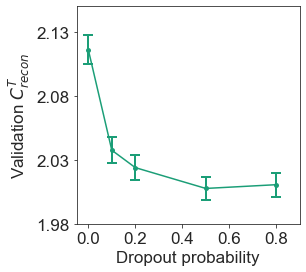

In [8]:
ax_txt_size = 17
sns.set_style('ticks')
fig_S1=plt.figure(figsize=(4, 4))
cc=plt.get_cmap('Dark2')
T_arr = np.empty((0,3))              
for i,key in enumerate(pdlist):
    X = np.mean(T_recon_loss[key][-50:,:],axis=0)
    T_arr = np.append(T_arr,np.array([[np.float(key.replace('-','.')),np.nanmean(X),np.nanstd(X)/np.sqrt(np.size(X))]]),axis=0)
       
plt.errorbar(T_arr[:,0],T_arr[:,1],T_arr[:,2],
             fmt='.-', c=cc(0), mfc=cc(0), ms=10, mec='None',  mew=2,
             ecolor=cc(0), elinewidth=2, capsize=5)

ax = plt.gca()
ax.set_xlim(-0.05,0.9)
ax.set_ylim(1.98,2.15)
ax.set_yticks(np.arange(1.98,2.16,0.05))
ax.set_xlabel('Dropout probability')
ax.set_ylabel('Validation $C_{recon}^{T}$')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(ax_txt_size)

fig_S1.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/FigS2.pdf',
               dpi=300, format='pdf', bbox_inches='tight')